In [1]:
from IPython.core.display import display,HTML

In [2]:
HTML('''<script>
    hideInput = () => $('div.input').hide();
</script>
<body onload="javascript:hideInput()"></body>''')

In [3]:
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

# Assignment 2 - Logistic Regression

***Student Details:***

- Name : Anjishnu Mukherjee
- Registration Number : B05-511017020
- Class Roll Number : CS Gy-70
- Exam Roll Number : 510517086
- Email : 511017020.anjishnu@students.iiests.ac.in

# Project Setup

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Load files and libraries, set seed

Source of Data : [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

In [3]:
%%capture
file_path = '/content/drive/My Drive/ML_LAB/Assign_2/cancer_wisconsin_data/' 
data_path = file_path + 'data.csv'

import platform
import random
import os
import sys
from collections import OrderedDict  
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def get_lib_versions():
  print("------------------------------------")
  output = OrderedDict()
  output["OS"] = platform.platform()
  output["Python version"] = sys.version.replace("\n", " ")
  output["Numpy version"] = np.version.full_version
  output["Pandas version"] = pd.__version__
  output["Matplotlib version"] = matplotlib.__version__
  output["Seaborn version"] = sns.__version__
  output["Scikitlearn version"] = sklearn.__version__
  for kv in output.items():
    print("%s: %s" % kv)
  print("------------------------------------")

def fix_seeds(seed=1337):
  SEED = seed
  random.seed(SEED)
  os.environ['PYTHONHASHSEED'] = str(SEED)
  np.random.seed(SEED)
  plt.rcParams['figure.figsize'] = (7.0, 7.0) 
  plt.rcParams['figure.dpi'] = 90  
  sns.set_style("dark")
  sns.set_context("paper")
  sns.set_palette("colorblind")
  print("Global Seed : ", SEED)
  print("------------------------------------")

In [4]:
print("Environment Information : ")
get_lib_versions()
fix_seeds(5 )

Environment Information : 
------------------------------------
OS: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
Numpy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2
Seaborn version: 0.10.1
Scikitlearn version: 0.22.2.post1
------------------------------------
Global Seed :  5
------------------------------------


# Pre-Processing


## Read dataset into Pandas dataframe

In [5]:
dataset = pd.read_csv(data_path)
print("Let's visualise the first 5 rows of the dataset.")
dataset.head() 

Let's visualise the first 5 rows of the dataset.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Remove columns that are not useful for the analysis

- ```id```
- ```Unnamed : 32```

In [6]:
dataset = dataset.drop(["id"], axis = 1)
dataset = dataset.drop(["Unnamed: 32"], axis = 1)

## Create Binary Class labels

In [7]:
dataset.diagnosis = [1 if i == "M" else 0 for i in dataset.diagnosis]

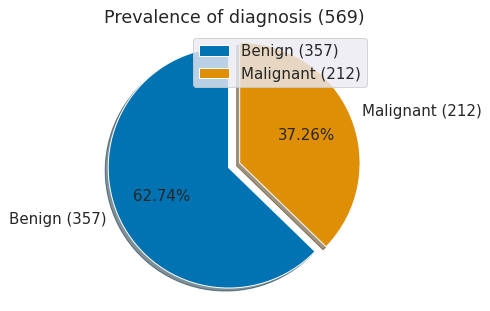

In [8]:
sum_D = len(dataset.diagnosis)
sum_M = (dataset.diagnosis.values==1).sum()
sum_B = sum_D - sum_M
frac_B = sum_B/sum_D
frac_M = 1 - frac_B
labels = 'Benign ('+str(sum_B)+')', 'Malignant ('+str(sum_M)+')'
sizes = [frac_B, frac_M]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90, textprops={'fontsize': 12})

ax1.set_title('Prevalence of diagnosis ('+str(sum_D)+')', fontsize=14)
ax1.axis('equal')
ax1.legend(fontsize=12, loc='best')
plt.show()

Clearly, there exists a class imbalance, with more number of Benign samples than Malignant samples.

# Feature Extraction

## Get training features and class labels

In [9]:
x = dataset.drop(["diagnosis"], axis = 1)
y = dataset.diagnosis.values

## Choose only the mean values for each feature as training features



In [10]:
print("All Features : ")
x.head()

All Features : 


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
x = x[["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"]]

In [12]:
print("Selected Features : ")
x.head()

Selected Features : 


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


## Check correlation between features and drop highly correlated ones

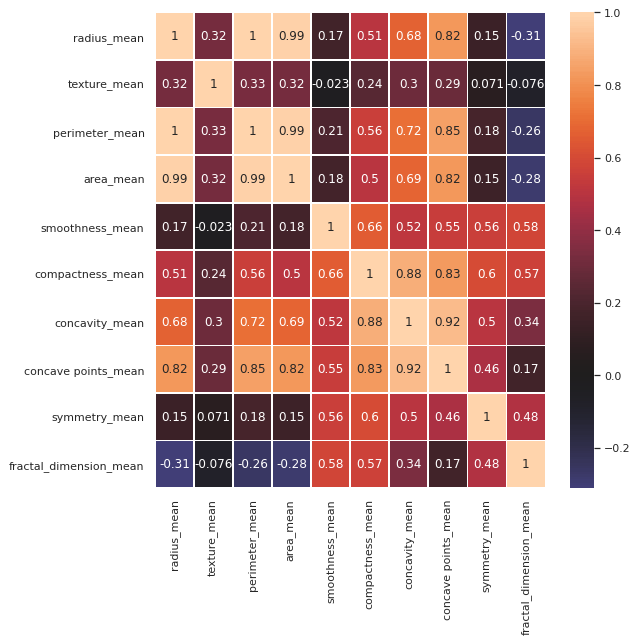

In [13]:
cor = x.corr()
sns.heatmap(cor, annot = True, center= 0, linewidth=0.5)
plt.show()

- As can be expected logically, ```perimeter_mean``` and ```area_mean``` are highly correlated with ```radius_mean```. So, I will be dropping ```perimeter_mean``` and ```area_mean``` features, keeping only ```radius_mean```.

- Apart from this, ```concave points_mean``` is highly correlated with ```radius_mean```.

- ```compactness_mean``` is highly correlated with ```concavity_mean``` and ```concave points_mean```.

- ```concavity_mean``` is highly correlated with ```concave points_mean```.

- But, if ```concave points_mean``` and ```concavity_mean```, are dropped, the accuracy drastically decreases from 95% or more to around 90% only, indicating that they are important features which shouldn't be dropped.

In [14]:
x = x.drop(columns=["perimeter_mean", "area_mean"])
print("Final features chosen: ")
x.head()

Final features chosen: 


,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


None of the final features have a correlation value greater than 0.9, so all of them are uniquely important for the analysis.


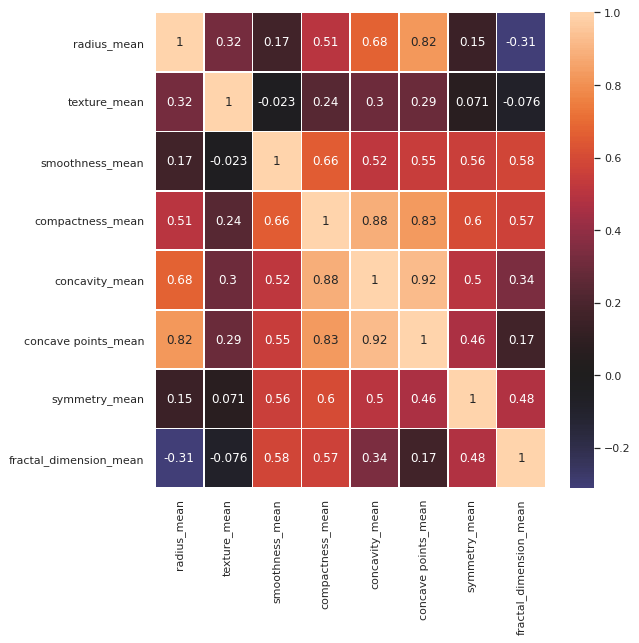

In [15]:
cor = x.corr()
sns.heatmap(cor, annot = True, center= 0, linewidth=0.5)
print("None of the final features have a correlation value greater than 0.9, so all of them are uniquely important for the analysis.")
plt.show()

## Normalise training features to the range (0,1)

In [16]:
x = (x - np.min(x)) / (np.max(x) - np.min(x))

In [17]:
x.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,0.521037,0.022658,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518
1,0.643144,0.272574,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323
2,0.601496,0.390260,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247
3,0.210090,0.360839,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000
4,0.629893,0.156578,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816


## Train:Test:Val split

In [18]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 1 - train_ratio, random_state = 5, shuffle = True, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio), random_state = 5, shuffle = False) 

print("------------------------------------")
print("The shapes of the different data : (n_samples,n_features)")
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("x val: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)
print("y val: ",y_test.shape)
print("------------------------------------")

------------------------------------
The shapes of the different data : (n_samples,n_features)
x train:  (455, 8)
x test:  (57, 8)
x val:  (57, 8)
y train:  (455,)
y test:  (57,)
y val:  (57,)
------------------------------------


Let's check the distribution of the diagnosis in the different splits.

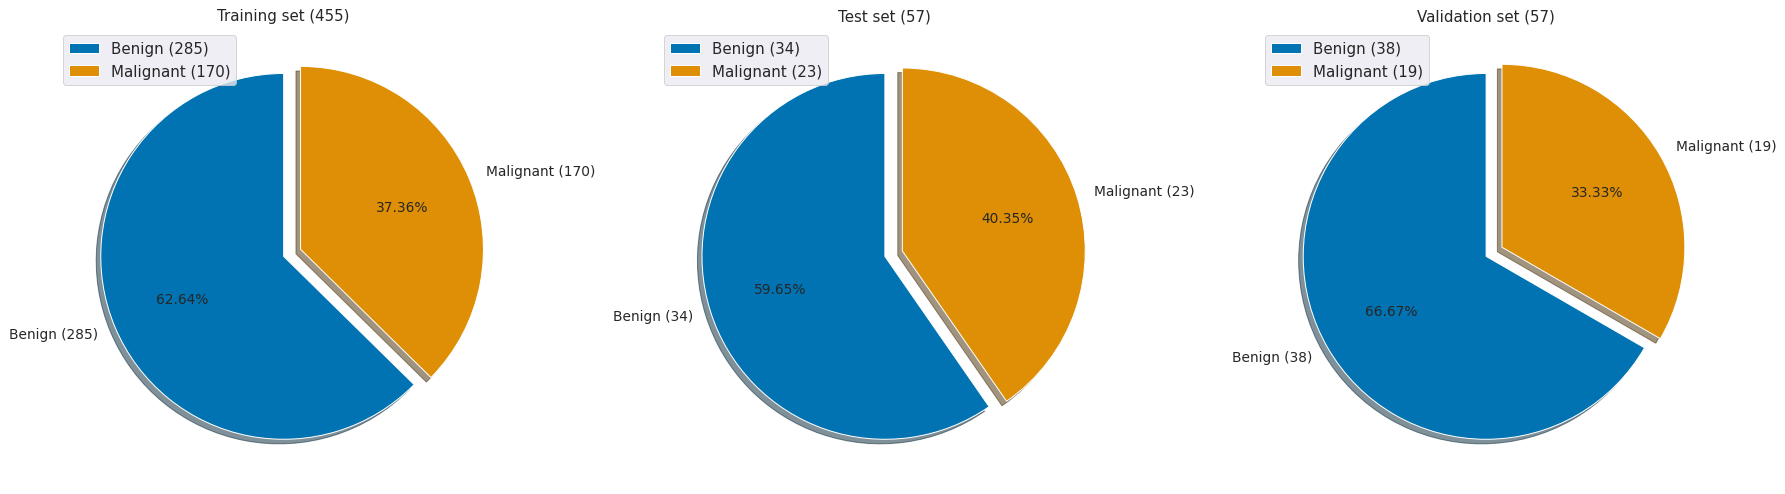

In [19]:
sum_tr  = len(y_train)
sum_tr_M = (y_train==1).sum()
sum_tr_B = sum_tr - sum_tr_M
frac_tr_B = sum_tr_B/sum_tr
frac_tr_M = 1 - frac_tr_B
sizes_tr = [frac_tr_B, frac_tr_M]
explode_tr = (0, 0.1)  # only "explode" the 2nd slice 
labels_tr = 'Benign ('+str(sum_tr_B)+')', 'Malignant ('+str(sum_tr_M)+')'

sum_ts   = len(y_test)
sum_ts_M = (y_test==1).sum()
sum_ts_B = sum_ts - sum_ts_M
frac_ts_B = sum_ts_B/sum_ts
frac_ts_M = 1 - frac_ts_B
sizes_ts = [frac_ts_B, frac_ts_M]
explode_ts = (0, 0.1)  # only "explode" the 2nd slice 
labels_ts = 'Benign ('+str(sum_ts_B)+')', 'Malignant ('+str(sum_ts_M)+')'

sum_val   = len(y_val)
sum_val_M = (y_val==1).sum()
sum_val_B = sum_val - sum_val_M
frac_val_B = sum_val_B/sum_val
frac_val_M = 1 - frac_val_B
sizes_val = [frac_val_B, frac_val_M]
explode_val = (0, 0.1)  # only "explode" the 2nd slice 
labels_val = 'Benign ('+str(sum_val_B)+')', 'Malignant ('+str(sum_val_M)+')'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes[0].pie(sizes_tr, explode=explode_tr, labels=labels_tr, autopct='%1.2f%%', shadow=True, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('Training set ('+str(sum_tr)+')', fontsize=12)
axes[0].legend(fontsize=12, loc='best')

axes[1].pie(sizes_ts, explode=explode_ts, labels=labels_ts, autopct='%1.2f%%', shadow=True, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Test set ('+str(sum_ts)+')', fontsize=12)
axes[1].legend(fontsize=12, loc='best')

axes[2].pie(sizes_val, explode=explode_val, labels=labels_val, autopct='%1.2f%%', shadow=True, startangle=90, textprops={'fontsize': 11})
axes[2].set_title('Validation set ('+str(sum_val)+')', fontsize=12)
axes[2].legend(fontsize=12, loc='best')

plt.tight_layout()
plt.show()

# Common functionality for all the classifiers

In [20]:
def Classification(model, clf_name, print_result):
    random_state = np.random.RandomState(5)

    # train the model
    model.fit(X_train, y_train)   

    # calculate accuracy scores
    score_train, score_test = model.score(X_train, y_train)*100, model.score(X_test, y_test)*100
    score_val = model.score(X_val, y_val)*100

    # get predictions on Test-set
    y_pred = model.predict(X_test)

    # confusion matrix 
    cm = confusion_matrix(y_test, y_pred)

    # classification report
    cr = classification_report(y_test, y_pred)

    if print_result:
        # Calculating the accuracies
        print('--- '+clf_name+' ---')

        # Print confusion matrix
        plt.rcParams['figure.figsize'] = (4, 4)
        sns.heatmap(cm, annot = True)
        plt.title('Confusion Matrix', fontsize = 14)
        plt.show()
        print(cr)
        print("------------------------------------------------")
        print('Training accuracy: %.2f [%%] \nTest accuracy :     %.2f [%%]\nValidation accuracy :     %.2f [%%]\n'%(score_train, score_test, score_val))
        if clf_name != 'clf20 - Naive Bayes Classifier':
          print("Coefficients :", model.coef_)

        if clf_name == 'clf20 - Naive Bayes Classifier':
          scores = cross_val_score(model, X_train, y_train, cv=5)
          print("Naive Bayes 5 fold cross validation score : ", scores)
          print("Cross Validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
    return model, cr
    
def Report(model, cr):
    model.fit(X_train, y_train) 
    clf_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    clf_probs = clf_probs[:, 1]
    # calculate scores
    clf_auc = roc_auc_score(y_test, clf_probs)
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_test, clf_probs)
    return cr, fpr, tpr, clf_auc

def extract_values( Str ): 
    # ---------- Extract metrics from string ---------- #
    get_acc = Str.split('accuracy')[1].split('\n')[0]
    Acc = float(get_acc.strip()[0:6])           # Remove irrelevant chars
    get_line = Str.split('weighted avg')[1].split('\n')[0]
    get_line = get_line.replace(" ", "")        # remove irrelevant chars
    Pr = float(get_line[0:5])
    Rc = float(get_line[4:8])
    F1 = float(get_line[8:12])
    return [Acc, Pr, Rc, F1]

def Compare():
  c_report, fpr, tpr, auc = dict(), dict(), dict(), dict()
  for i in range(len(clf_dict)):
      model, cr = Classification(clf_dict[i], clf_names[i], print_result=False)
      c_report[i], fpr[i], tpr[i], auc[i] = Report(model, cr)
      
  len_X = len(clf_dict)
  Acc, Pr, Rc, F1 = np.zeros(len_X), np.zeros(len_X), np.zeros(len_X), np.zeros(len_X)

  for i in range(len_X):
      Acc[i], Pr[i], Rc[i], F1[i] = np.asarray( extract_values( c_report[i] ) )
      
  barWidth = 0.125
  r1 = np.arange(len_X)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]


  # Make the plot
  plt.rcParams['figure.figsize'] = (20, 5)
  plt.bar(r1, Acc, color='#3498db', width=barWidth, edgecolor='white', label='Accuracy')
  plt.bar(r2, Pr,  color='#e74c3c', width=barWidth, edgecolor='white', label='Precision')
  plt.bar(r3, Rc,  color='#2d7f5e', width=barWidth, edgecolor='white', label='Recall')
  plt.bar(r4, F1,  color='yellow', width=barWidth, edgecolor='white', label='F1 score')
  
  # Add xticks on the middle of the group bars
  plt.title('Performance comparison on test data', fontsize = 16)
  plt.xlabel('Classifiers', fontsize=14)
  plt.xticks([r + barWidth for r in range(len(clf_names))], [r for r in clf_names], fontsize=11, weight='bold')
  plt.yticks(fontsize=13)

  min_value = np.concatenate( (Acc, Pr, Rc, F1) ).min()
  plt.ylim([0.95*min_value, 1.0]) 
  plt.rcParams['figure.figsize'] = (20, 4)
  plt.legend(['Accuracy', 'Precision', 'Recall', 'F1 score'], fontsize=12, loc='best')
  plt.show()
  return

In [21]:
# -------------- List of Classifiers -------------- #
clf_dict = dict()         
clf_dict[0] = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=10000, random_state=5)
clf_dict[1] = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, random_state=5)
clf_dict[2] = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, random_state=5)
clf_dict[3] = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000, random_state=5)
clf_dict[4] = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, random_state=5)
clf_dict[5] = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000, random_state=5)
clf_dict[6] = LogisticRegression(penalty='none', solver='newton-cg', max_iter=10000, random_state=5)
clf_dict[7] = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=10000, random_state=5)
clf_dict[8] = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000, random_state=5)
clf_dict[9] = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, random_state=5)
clf_dict[10] = LogisticRegression(penalty='none', solver='sag', max_iter = 10000, random_state=5)
clf_dict[11] = LogisticRegression(penalty='l2', solver='sag', max_iter=10000, random_state=5)
clf_dict[12] = LogisticRegression(penalty='none', solver='saga', max_iter=10000, random_state=5)
clf_dict[13] = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state=5)
clf_dict[14] = LogisticRegression(penalty='l2', solver='saga', max_iter=10000, random_state=5)
clf_dict[15] = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, solver='saga', max_iter=10000, random_state=5)
clf_dict[16] = LogisticRegression(penalty='elasticnet', l1_ratio=0.25, solver='saga', max_iter=10000, random_state=5)
clf_dict[17] = LogisticRegression(penalty='elasticnet', l1_ratio=0.75, max_iter=10000, solver='saga', random_state=5)
clf_dict[18] = LogisticRegression(penalty='elasticnet', l1_ratio=0.9, solver='saga', max_iter=10000, random_state=5)
clf_dict[19] = GaussianNB()

clf_names = ['clf1', 'clf2', 'clf3', 'clf4', 'clf5', 'clf6', 'clf7', 'clf8', 'clf9', 'clf10', 'clf11', 'clf12', 'clf13', 'clf14', 'clf15', 'clf16', 'clf17', 'clf18', 'clf19', 'clf20']

# Logistic Regression Classifier

[Scikit-learn Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

```python
class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
```

- ```penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’```
- ```solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’```
- ```l1_ratio : float, default=None```
- train : ```fit(X, y, sample_weight=None)```
- accuracy : ```score(X, y, sample_weight=None)```
- coef_ : ```class attribute, an ndarray of shape (1, n_features) or (n_classes, n_features)```

**NOTE:** I am using ```max_iter=10000``` for all the models below, because not all of the models converge at the default ```max_iter=100``` parameter value and using the same value for all of them will allow us to compare better.


### Use the following solvers to train the  Logistic regression model, and create a table for the coefficients of all the features along with accuracy.  

- ```newton-cg``` with ```l2``` penalty
- ```lbfgs``` with ```l2``` penalty
- ```liblinear``` with ```l1``` penalty
- ```liblinear``` with ```l2``` penalty


Order of features : <br>
```
"radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
```

| Solver        | Penalty | Accuracy(train)[%] | Accuracy(test)[%]  | Accuracy(val)[%]  | Coefficient weights |
| :-------------|:----------------|:-------------|:----------------|:-------------| :-------------|
| newton-cg | l2 | 94.29 | 94.74 | 87.72 | [ 4.45380086 2.576318 1.04456251 1.82756215 3.00336032 4.47596551 0.79653781 -1.52345787] |
| lbfgs | l2 | 94.29 | 94.74 | 87.72 | [ 4.45389396  2.57633691  1.04454159  1.82765517  3.0031218   4.47615744 0.79631567 -1.52325571] |
| liblinear | l1 | 94.07 | 94.74 | 89.47 | [ 7.40636798  4.22252032  0.          0.          0.11135969 13.30880323 0.          0.        ] |
| liblinear | l2 | 93.85 | 94.74 | 87.72 | [ 3.53850121  1.79244856  0.27844959  1.77462518  3.11787662  4.5441479 0.16363766 -1.91358428] |

--- clf1 - LogisticRegression, Newton-cg solver, L2 penalty ---


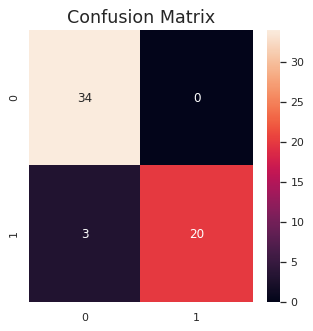

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45380086  2.576318    1.04456251  1.82756215  3.00336032  4.47596551
   0.79653781 -1.52345787]]


In [22]:
name = 'clf1 - LogisticRegression, Newton-cg solver, L2 penalty'
_, _ = Classification(clf_dict[0], name, True)

--- clf2 - LogisticRegression, LBFGS solver, L2 penalty ---


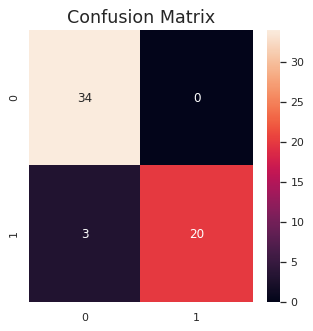

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45389396  2.57633691  1.04454159  1.82765517  3.0031218   4.47615744
   0.79631567 -1.52325571]]


In [23]:
name = 'clf2 - LogisticRegression, LBFGS solver, L2 penalty'
_, _ = Classification(clf_dict[1], name, True)

--- clf3 - LogisticRegression, Liblinear solver, L1 penalty ---


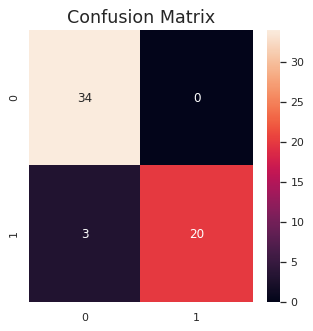

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.07 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     89.47 [%]

Coefficients : [[ 7.40636798  4.22252032  0.          0.          0.11135969 13.30880323
   0.          0.        ]]


In [24]:
name = 'clf3 - LogisticRegression, Liblinear solver, L1 penalty'
_, _ = Classification(clf_dict[2], name, True)

--- clf4 - LogisticRegression, Liblinear solver, L2 penalty ---


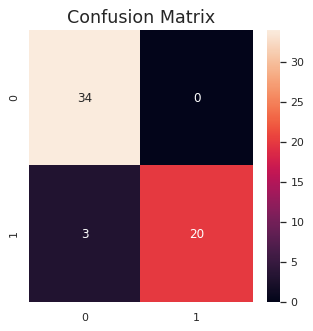

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 93.85 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 3.53850121  1.79244856  0.27844959  1.77462518  3.11787662  4.5441479
   0.16363766 -1.91358428]]


In [25]:
name = 'clf4 - LogisticRegression, Liblinear solver, L2 penalty'
_, _ = Classification(clf_dict[3], name, True)

### Use the following penalties to train the  Logistic regression model, and create a table for the coefficients of all the features along with accuracy.  

- ```l1``` (```liblinear```, ```saga```)
- ```l2``` (```liblinear```, ```newton-cg```, ```lbfgs```, ```sag```, ```saga```)
- ```none``` (```newton-cg```, ```lbfgs```, ```sag```, ```saga```)


Order of features : <br>
```
"radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
```

| Solver        | Penalty | Accuracy(train)[%] | Accuracy(test)[%]  | Accuracy(val)[%]  | Coefficient weights |
| :-------------|:----------------|:-------------|:----------------|:-------------| :-------------|
| liblinear | l1 | 94.07 | 94.74 | 89.47 | [ 7.40636798  4.22252032  0.          0.          0.11135969 13.30880323  0.          0.        ] |
| liblinear | l2 | 93.85 | 94.74 | 87.72 | [ 3.53850121  1.79244856  0.27844959  1.77462518  3.11787662  4.5441479  0.16363766 -1.91358428] |
| newton-cg | none | 94.29 | 96.49 | 94.74 | [20.06080691  9.79144373  6.02660277 -4.99278236  5.21227594 11.41132691  2.88539804  0.56940418] |
| newton-cg | l2 | 94.29 | 94.74 | 87.72 | [ 4.45380086  2.576318    1.04456251  1.82756215  3.00336032  4.47596551  0.79653781 -1.52345787] |
| lbfgs     | none | 94.29 | 96.49 | 94.74 | [20.06045485  9.79210803  6.027527   -4.99257488  5.21317842 11.41166854  2.8852017   0.56825058] |
| lbfgs     | l2 | 94.29 | 94.74 | 87.72 | [ 4.45389396  2.57633691  1.04454159  1.82765517  3.0031218   4.47615744  0.79631567 -1.52325571] |
| sag       | none | 94.29 | 96.49 | 94.74 | [19.91735187  9.76711429  5.99789444 -4.89223013  5.2161634  11.41852398  2.87431834  0.47000516] |
| sag       | l2 | 94.29 | 94.74 | 87.72 | [ 4.45411004  2.57608399  1.04458306  1.82746343  3.00349339  4.47599915  0.79667436 -1.52357123] |
| saga      | none | 94.29 | 96.49 | 94.74 | [19.77035463  9.74256455  5.96495113 -4.79296545  5.21679348 11.4330715  2.86359208  0.37200825] |
| saga      | l1 | 94.07 | 94.74 | 89.47 | [ 8.42970344  4.86702925  0.          0.          0.358749   13.60396262 0.          0.        ] |
| saga      | l2 | 94.29 | 94.74 | 87.72 | [ 4.45190129  2.57560039  1.04356631  1.82819322  3.0037066   4.47682355  0.79591324 -1.52439029] |

A general observation can be made from this table, that L1 assigns zero coefficients to some of the features, namely ```"smoothness_mean", "compactness_mean", "symmetry_mean", "fractal_dimension_mean"```, while still retaining a high accuracy on test data, indicating that those features do not influence the final decision boundary a lot.

--- clf5 - LogisticRegression, Liblinear solver, L1 penalty ---


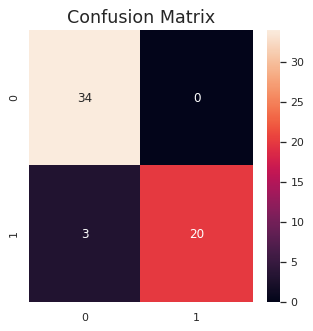

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.07 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     89.47 [%]

Coefficients : [[ 7.40636798  4.22252032  0.          0.          0.11135969 13.30880323
   0.          0.        ]]


In [26]:
name = 'clf5 - LogisticRegression, Liblinear solver, L1 penalty'
_, _ = Classification(clf_dict[4], name, True)

--- clf6 - LogisticRegression, Liblinear solver, L2 penalty ---


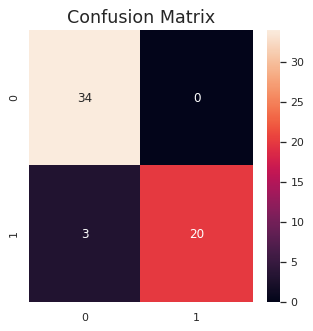

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 93.85 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 3.53850121  1.79244856  0.27844959  1.77462518  3.11787662  4.5441479
   0.16363766 -1.91358428]]


In [27]:
name = 'clf6 - LogisticRegression, Liblinear solver, L2 penalty'
_, _ = Classification(clf_dict[5], name, True)

--- clf7 - LogisticRegression, Newton-cg solver, no penalty ---


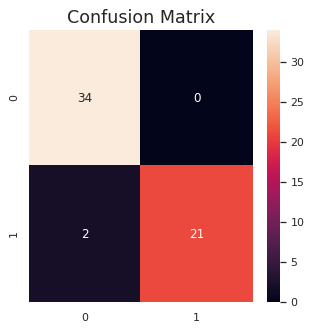

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.91      0.95        23

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     96.49 [%]
Validation accuracy :     94.74 [%]

Coefficients : [[20.06080691  9.79144373  6.02660277 -4.99278236  5.21227594 11.41132691
   2.88539804  0.56940418]]


In [28]:
name = 'clf7 - LogisticRegression, Newton-cg solver, no penalty'
_, _ = Classification(clf_dict[6], name, True)

--- clf8 - LogisticRegression, Newton-cg solver, L2 penalty ---


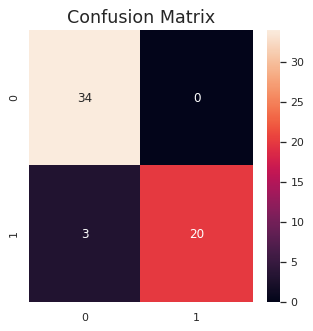

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45380086  2.576318    1.04456251  1.82756215  3.00336032  4.47596551
   0.79653781 -1.52345787]]


In [29]:
name = 'clf8 - LogisticRegression, Newton-cg solver, L2 penalty'
_, _ = Classification(clf_dict[7], name, True)

--- clf9 - LogisticRegression, LBFGS solver, no penalty ---


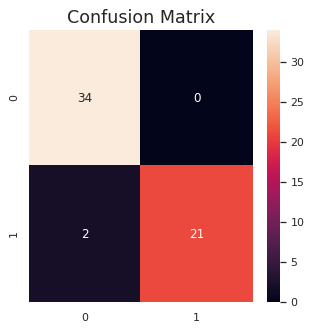

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.91      0.95        23

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     96.49 [%]
Validation accuracy :     94.74 [%]

Coefficients : [[20.06045485  9.79210803  6.027527   -4.99257488  5.21317842 11.41166854
   2.8852017   0.56825058]]


In [30]:
name = 'clf9 - LogisticRegression, LBFGS solver, no penalty'
_, _ = Classification(clf_dict[8], name, True)

--- clf10 - LogisticRegression, LBFGS solver, L2 penalty ---


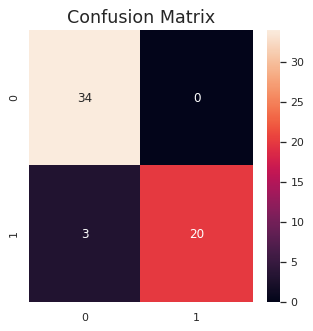

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45389396  2.57633691  1.04454159  1.82765517  3.0031218   4.47615744
   0.79631567 -1.52325571]]


In [31]:
name = 'clf10 - LogisticRegression, LBFGS solver, L2 penalty'
_, _ = Classification(clf_dict[9], name, True)

--- clf11 - LogisticRegression, SAG solver, no penalty ---


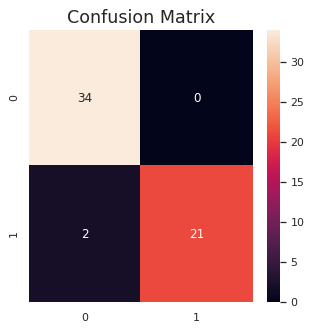

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.91      0.95        23

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     96.49 [%]
Validation accuracy :     94.74 [%]

Coefficients : [[19.91735187  9.76711429  5.99789444 -4.89223013  5.2161634  11.41852398
   2.87431834  0.47000516]]


In [32]:
name = 'clf11 - LogisticRegression, SAG solver, no penalty'
_, _ = Classification(clf_dict[10], name, True)

--- clf12 - LogisticRegression, SAG solver, L2 penalty ---


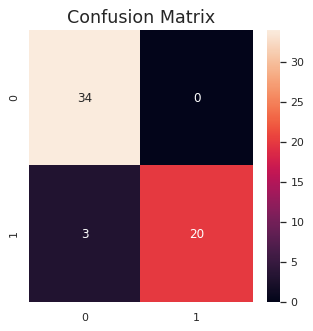

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45411004  2.57608399  1.04458306  1.82746343  3.00349339  4.47599915
   0.79667436 -1.52357123]]


In [33]:
name = 'clf12 - LogisticRegression, SAG solver, L2 penalty'
_, _ = Classification(clf_dict[11], name, True)

--- clf13 - LogisticRegression, SAGA solver, no penalty ---


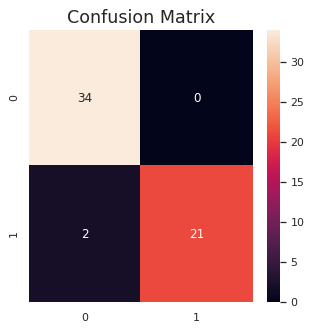

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       1.00      0.91      0.95        23

    accuracy                           0.96        57
   macro avg       0.97      0.96      0.96        57
weighted avg       0.97      0.96      0.96        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     96.49 [%]
Validation accuracy :     94.74 [%]

Coefficients : [[19.77035463  9.74256455  5.96495113 -4.79296545  5.21679348 11.4330715
   2.86359208  0.37200825]]


In [34]:
name = 'clf13 - LogisticRegression, SAGA solver, no penalty'
_, _ = Classification(clf_dict[12], name, True)

--- clf14 - LogisticRegression, SAGA solver, L1 penalty ---


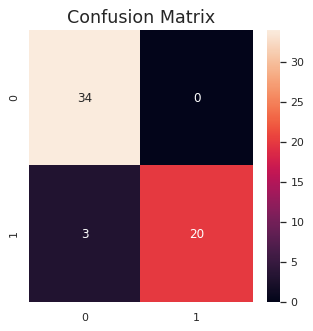

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.07 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     89.47 [%]

Coefficients : [[ 8.42970344  4.86702925  0.          0.          0.358749   13.60396262
   0.          0.        ]]


In [35]:
name = 'clf14 - LogisticRegression, SAGA solver, L1 penalty'
_, _ = Classification(clf_dict[13], name, True)

--- clf15 - LogisticRegression, SAGA solver, L2 penalty ---


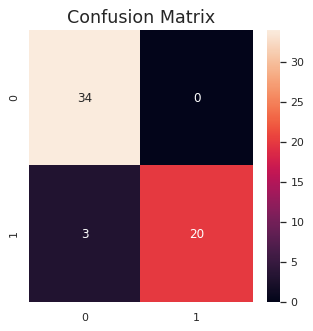

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.45190129  2.57560039  1.04356631  1.82819322  3.0037066   4.47682355
   0.79591324 -1.52439029]]


In [36]:
name = 'clf15 - LogisticRegression, SAGA solver, L2 penalty'
_, _ = Classification(clf_dict[14], name, True)

### Use ```saga``` solver with ```elasticnet``` regularisation to vary ```l1_ratio``` as the following values and compare the coefficients of the features.

- ```0.1```
- ```0.25```
- ```0.75```
- ```0.9```

Order of features : <br>
```
"radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
```

| l1_ratio  | Accuracy(train)[%] | Accuracy(test)[%]  | Accuracy(val)[%]  | Coefficient weights |
|:----------------|:-------------|:----------------|:-------------| :-------------|
| 0.1 | 94.29 | 94.74 | 87.72 | [ 4.60659571  2.64809395  1.02746134  1.8087179   3.04465057  4.63232396  0.76352765 -1.51431959] |
| 0.25| 94.07 | 94.74 | 87.72 | [ 4.8817629   2.77556618  0.99548831  1.759441    3.10650555  4.91297429  0.70335029 -1.48104431] |
| 0.75| 93.85 | 92.98 | 89.47 | [ 6.749833    3.54978108  0.63318013  0.84112826  3.12386511  7.00192294  0.27068212 -0.62110817] |
| 0.9 | 94.07 | 94.74 | 87.72 | [7.89036586e+00 4.05473855e+00 1.73055150e-01 0.00000000e+00 2.67297890e+00 9.20172174e+00 5.54894702e-03 0.00000000e+00] |


--- clf16 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.1 ---


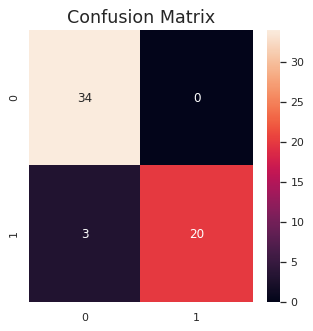

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.29 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.60659571  2.64809395  1.02746134  1.8087179   3.04465057  4.63232396
   0.76352765 -1.51431959]]


In [37]:
name = 'clf16 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.1'
_, _ = Classification(clf_dict[15], name, True)

--- clf17 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.25 ---


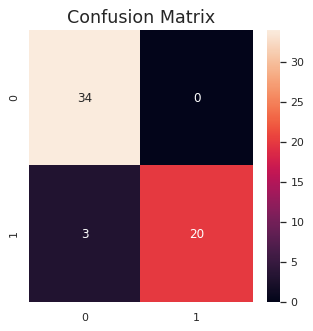

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.07 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[ 4.8817629   2.77556618  0.99548831  1.759441    3.10650555  4.91297429
   0.70335029 -1.48104431]]


In [38]:
name = 'clf17 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.25'
_, _ = Classification(clf_dict[16], name, True)

--- clf18 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.75 ---


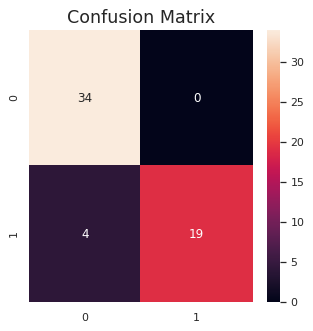

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       1.00      0.83      0.90        23

    accuracy                           0.93        57
   macro avg       0.95      0.91      0.92        57
weighted avg       0.94      0.93      0.93        57

------------------------------------------------
Training accuracy: 93.85 [%] 
Test accuracy :     92.98 [%]
Validation accuracy :     89.47 [%]

Coefficients : [[ 6.749833    3.54978108  0.63318013  0.84112826  3.12386511  7.00192294
   0.27068212 -0.62110817]]


In [39]:
name = 'clf18 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.75'
_, _ = Classification(clf_dict[17], name, True)

--- clf19 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.9 ---


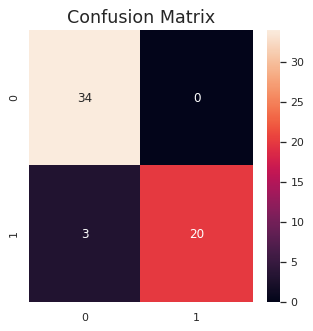

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.87      0.93        23

    accuracy                           0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

------------------------------------------------
Training accuracy: 94.07 [%] 
Test accuracy :     94.74 [%]
Validation accuracy :     87.72 [%]

Coefficients : [[7.89036586e+00 4.05473855e+00 1.73055150e-01 0.00000000e+00
  2.67297890e+00 9.20172174e+00 5.54894702e-03 0.00000000e+00]]


In [40]:
name = 'clf19 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.9'
_, _ = Classification(clf_dict[18], name, True)

# Naive Bayes Classifier

[Gaussian Naive Bayes using sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)



```python
class sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09)
```

- ```fit(X, y, sample_weight=None)```
- ```score(X, y, sample_weight=None)```

### Estimate the average accuracy of the Naive Bayes algorithm using 5-fold cross-validation.


--- clf20 - Naive Bayes Classifier ---


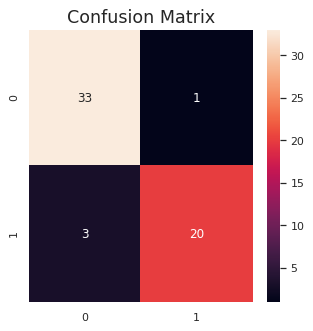

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       0.95      0.87      0.91        23

    accuracy                           0.93        57
   macro avg       0.93      0.92      0.93        57
weighted avg       0.93      0.93      0.93        57

------------------------------------------------
Training accuracy: 92.97 [%] 
Test accuracy :     92.98 [%]
Validation accuracy :     87.72 [%]

Naive Bayes 5 fold cross validation score :  [0.92307692 0.95604396 0.93406593 0.87912088 0.91208791]
Cross Validated Accuracy: 0.92 (+/- 0.05)


In [41]:
name = 'clf20 - Naive Bayes Classifier'
_, _ = Classification(clf_dict[19], name, True)

# Compare all the classifiers

- Plot the bar graph using matplotlib.

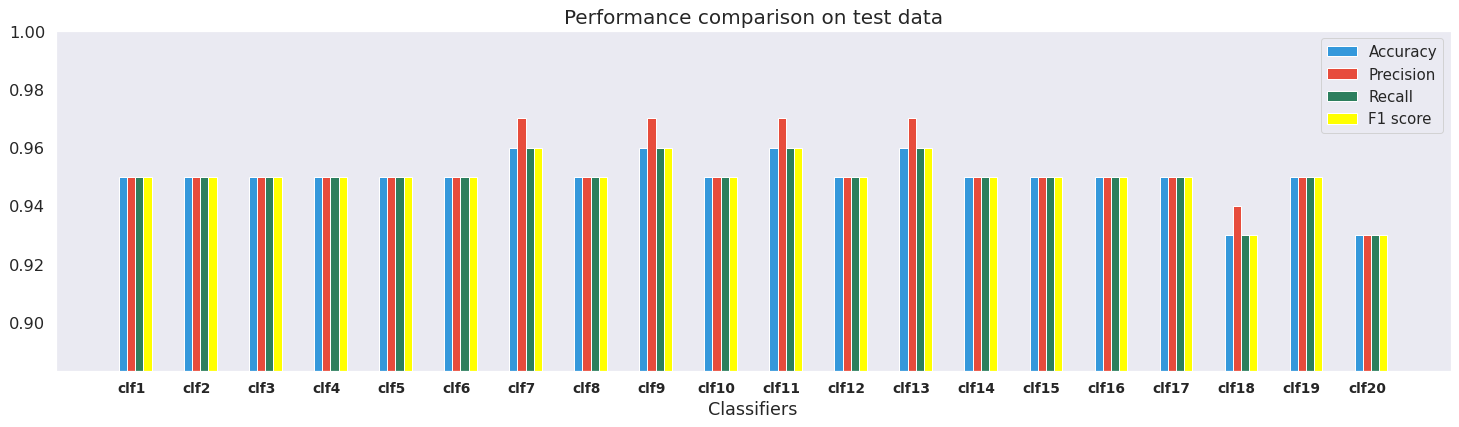

In [42]:
Compare()


- clf1 - LogisticRegression, Newton-cg solver, L2 penalty
- clf2 - LogisticRegression, LBFGS solver, L2 penalty
- clf3 - LogisticRegression, Liblinear solver, L1 penalty
- clf4 - LogisticRegression, Liblinear solver, L2 penalty
- clf5 - LogisticRegression, Liblinear solver, L1 penalty
- clf6 - LogisticRegression, Liblinear solver, L2 penalty
- clf7 - LogisticRegression, Newton-cg solver, no penalty
- clf8 - LogisticRegression, Newton-cg solver, L2 penalty
- clf9 - LogisticRegression, LBFGS solver, no penalty
- clf10 - LogisticRegression, LBFGS solver, L2 penalty
- clf11 - LogisticRegression, SAG solver, no penalty
- clf12 - LogisticRegression, SAG solver, L2 penalty
- clf13 - LogisticRegression, SAGA solver, no penalty
- clf14 - LogisticRegression, SAGA solver, L1 penalty
- clf15 - LogisticRegression, SAGA solver, L2 penalty
- clf16 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.1
- clf17 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.25
- clf18 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.75
- clf19 - LogisticRegression, SAGA solver, elasticnet penalty, l1_ratio=0.9
- clf20 - Naive Bayes Classifier
